# Sentiment Analysis


**What is Sentiment Analysis**?

Sentiment Analysis (SA), also known as Opinion Mining (OM), is a popular application of Natural Language Processing (NLP), involving the processing of text chunks in order to determine whether a they expresses a positive, negative, or neutral sentiment.

Automating this kind of information extraction processes can be of great help for companies and other types of institutions for real-time customer feedback analysis and reputation monitoring on social media among other applications.

**What are the applications of Sentiment Analysis?**

There are a number of relevant use-cases of Sentiment Analysis, such as:
- Customer Feedback Analysis
-	Market Research
-	Social Media monitoring
-	Political Analysis and Election Forecasting
-	Financial Analysis
-	Health care

**What are the methods to perform Sentiment Analysis?**

Different approaches are possible relying on different kinds of techniques:
- Lexicon/rule based: It analyze the sentiment based on predefined dictionaries of words and associated scores. TextBlob, VADER, MPQA, LIWC are some ways of this approach.
- Machine Learning based: The ML models learn patterns from the sentence and associated sentiment, then predicts the sentiment for new text. The classification models like logistic regression, SVM, Random Forest, XGBoost or others can be used in this case.
- Deep Learning baseds: RNNs, LSTMs, Transformers and other sequential models can be used to capture the complex patterns of sequence in the text data. Transformers perform state of the art performance in this case.



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, accuracy_score

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Restaurant's example


Client has shared historic data on customer reviews for their restaurant along with positive/negative labels. Additionally, they have shared a fresh customer review dump with us to generate labels. So, our deliverables to the client would be:
*   a sentiment-based binary review classification model, and
*   labelling on fresh reviews dump as positives/negatives

Files we have to work on:
1. historical review dataset with plain text reviews plus label indicating sentiment (1 = positive, 0 = negative) -> train dataset
2. dataset of new reviews to classify -> test dataset

Remember we are dealing with *text* input data. Phases of the work will include:
- **Data preprocessing**: we'll want to filter out the unwanted/unnecessary parts of the text (could be digits, characters, words)
- **Text-to-numeric representation**: computers only work with numbers! So, we need a way to represent our data in numeric form.

In [ ]:
df = pd.read_csv('a1_RestaurantReviews_HistoricDump.tsv', delimiter = '\t')
# use 'quoting' parameter to handle potential quoted text in original csv file
df.head()

,Review,Liked
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  900 non-null    object
 1   Liked   900 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 14.2+ KB


In [ ]:
df.Liked.value_counts() # quite balanced

,count
Liked,
1,496
0,404


### Text preprocessing with NLTK

The purpose here is to remove non-value-adding characters and other words that would otherwise unnecessarily consume computational resources.

In [ ]:
import re # for regex
import nltk # nlp toolkit

nltk.download('stopwords')
# download dataset of stopwords ('the', 'is', 'at', ...)
# collection of stopwords in multiple languages

from nltk.corpus import stopwords


all_stopwords = stopwords.words('english') # 197 stopwords
all_stopwords.remove('not') # negation is pretty important for our purposes!

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Brief parenthesis: compare stemming and lemmatization
# Stemming: simpler, less accurate but faster
# Lemmatization: slower, but more accurate and precise
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.stem.porter import PorterStemmer
from nltk import pos_tag # edit: lemmatization works better if given POS tags
# example:
# "I saw the movie" saw is verb -> see
# "The sharp saw" saw is a noun -> saw

nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')


ps = PorterStemmer() # stemming algorithm (reduce words to their root form)
lem = WordNetLemmatizer() # lemmatization algorithm (reduce words to their lemma)


words = ['running', 'studies', 'better', 'connections', 'worst'] # sample words
# if custom sentence:
#from nltk.tokenize import word_tokenize
#tokens = word_tokenize(sentence)

tagged_tokens = pos_tag(words) # pos_tag is trained with Treebank tags

print("Example of tagged words:\n")
print(tagged_tokens[:5])

def get_wordnet_pos(treebank_tag):
    '''
    See https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html
    for a complete list of the Penn Treebank POS tags
    '''
    if treebank_tag.startswith('J'):  # adjectives (JJ, JJR, JJS) for normal, comparative, superlative
        return 'a' # == wordnet.ADJ
    elif treebank_tag.startswith('V'):  # verbs, many tags depending on the tense and person
        return 'v' # == wordnet.VERB
    elif treebank_tag.startswith('N'):  # nouns, vary depending on number and proper/common
        return 'n' # == wordnet.NOUN
    elif treebank_tag.startswith('R'):  # adverbs
        return 'r' # == wordnet.ADV
    else:
        return 'n'

print()
print(f"Word:{' ':7} | Stemming:{' ':9} | Lemmatization:")
for t in tagged_tokens:
    print(f"{t[0]:12} | stem: {ps.stem(t[0]):12} | lemma: {lem.lemmatize(t[0], get_wordnet_pos(t[1])):12}")
    # :12 and :10 reserve respectively 12 and 10 characters for what I'm printing

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


Example of tagged words:

[('running', 'VBG'), ('studies', 'NNS'), ('better', 'RBR'), ('connections', 'NNS'), ('worst', 'VBP')]

Word:        | Stemming:          | Lemmatization:
running      | stem: run          | lemma: run         
studies      | stem: studi        | lemma: study       
better       | stem: better       | lemma: well        
connections  | stem: connect      | lemma: connection  
worst        | stem: worst        | lemma: worst       


In [ ]:
lem.lemmatize("worst", wordnet.ADJ)

'bad'

In [ ]:
from nltk.tokenize import word_tokenize

text_corpus_stemmed = [] # putting together a polished text corpus, init empty list
text_corpus_lemmatized = []

# Before: "Wow... Loved this place.""

for i in range(0, df.shape[0]): # loop over dataframe
  review = re.sub('[^a-zA-Z]', ' ', df['Review'][i]) # re.sub(pattern, replacement, text)
  # [^a-zA-Z] means everything that is not a lowercase or uppercase character (digits, punctuation)
  # we're replacing any of it with spaces
  review = review.lower() # everything lowercase
  review_stem = review.split() # splits single review in parts, whitespace is default separator
  review_stem = [ps.stem(word) for word in review_stem if not word in set(all_stopwords)] # remove stopwords + stemming
  review_stem = ' '.join(review_stem) # join again stemmed words in sentence separated by spaces

  review_lemm = review.split() #word_tokenize(review)
  review_lemm = pos_tag(review_lemm)
  review_lemm = [lem.lemmatize(t[0], get_wordnet_pos(t[1])) for t in review_lemm if not t in set(all_stopwords)]
  review_lemm = ' '.join(review_lemm)

  # After: "wow love place"
  text_corpus_stemmed.append(review_stem)
  text_corpus_lemmatized.append(review_lemm)

In [ ]:
review, review_stem, review_lemm

('overall  a great experience ',
 'overal great experi',
 'overall a great experience')

In [ ]:
text_corpus_stemmed[:5]

['wow love place',
 'crust not good',
 'not tasti textur nasti',
 'stop late may bank holiday rick steve recommend love',
 'select menu great price']

In [ ]:
text_corpus_lemmatized[:5]

['wow love this place',
 'crust be not good',
 'not tasty and the texture be just nasty',
 'stop by during the late may bank holiday off rick steve recommendation and love it',
 'the selection on the menu be great and so be the price']

> REGEX parenthesis <br>
`[...]` matches anything specified between the brackets <br>
`^` means negation, so _not_ what follows <br>
`a-z` is the set of lowercase characters <br>
`A-Z` is the set of uppercase charaters <br>
`0-9` is the standard set of digits <br>
`.`	is any single character (except newline) <br>
`\d` means any digit, like `[0-9]` <br>
`\D` means any non-digit, like `[^0-9]` <br>
`\w` means any "word" char (either letters, digits, _and_ underscore), like `[a-zA-Z0-9_]` <br>
`\W` means any non-word char, like `[^a-zA-Z0-9_]` <br>
`\s` means a whitespace (space, tab, newline, carriage return, form feed, vertical tab) like	`[ \t\n\r\f\v]` <br>
`\S` means a non-whitespace, like	`[^ \t\n\r\f\v]`



Then go to Vectorization chapter!

### Vectorization

In [ ]:
# feature extraction (from text to number)
from sklearn.feature_extraction.text import CountVectorizer
cv1 = CountVectorizer(max_features = 1420)
cv2 = CountVectorizer(max_features = 1420)

'''
CountVectorizer transforms a *list* of documents into a matrix; where:
- the rows are the documents (each review)
- the columns are all the unique words appearing in the corpus (actually not the real world, but an index)
  the words are actually arranges in alphabetical order
- the cell values indicate the frequency (number of times) that a given word appears in a given document
N.B. This is a "bag of words" representation, where the word order or sequencing or words is not considered
N.B.2 This can create a rather sparse matrix
N.B.3 max_features limits to 1420 the number of *most common* words to keep in vocabulary, discarding
      too irrelevant words, to reduce overfitting and keep the feature matrix small

         |   w1   |   w2   |   w3   |  ...  |
|   d1   |    0   |    1   |    0   |  ...  |
|   d2   |    1   |    0   |    0   |  ...  |
|   d3   |    0   |    0   |    1   |  ...  |
|   ...  |   ...  |   ...  |   ...  |  ...  |

'''

'\nCountVectorizer transforms a *list* of documents into a matrix; where:\n- the rows are the documents (each review)\n- the columns are all the unique words appearing in the corpus (actually not the real world, but an index)\n  the words are actually arranges in alphabetical order\n- the cell values indicate the frequency (number of times) that a given word appears in a given document\nN.B. This is a "bag of words" representation, where the word order or sequencing or words is not considered\nN.B.2 This can create a rather sparse matrix\nN.B.3 max_features limits to 1420 the number of *most common* words to keep in vocabulary, discarding\n      too irrelevant words, to reduce overfitting and keep the feature matrix small\n\n         |   w1   |   w2   |   w3   |  ...  |\n|   d1   |    0   |    1   |    0   |  ...  |\n|   d2   |    1   |    0   |    0   |  ...  |\n|   d3   |    0   |    0   |    1   |  ...  |\n|   ...  |   ...  |   ...  |   ...  |  ...  |\n\n'

In [ ]:
X_stem = cv1.fit_transform(text_corpus_stemmed).toarray() # dictionary stemmed
X_lemm = cv2.fit_transform(text_corpus_lemmatized).toarray() # dictionary lemmatized
y = df.iloc[:, -1].values # labels

In [ ]:
# Saving BoW dictionary to later use in prediction
# import pickle
# bow_path = 'c1_BoW_Sentiment_Model.pkl'
# pickle.dump(cv, open(bow_path, "wb"))

> VECTORIZATION parenthesis <br>
Vectorization in NLP includes **Bag-of-Words** (BoW) models, like One-Hot encoding, CountVectorizer and TF-IDF, that all represent text by word frequency or count, and **Word Embeddings**, such as Word2Vec, GloVe, and BERT, that are more focused on capturing semantics and deal with dense vectors.

### Train and test split

In [ ]:
# Dividing dataset into train and test sets
from sklearn.model_selection import train_test_split

X_train1, X_test1, y_train1, y_test1 = train_test_split(X_stem, y, test_size = 0.20, random_state = 0)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_lemm, y, test_size = 0.20, random_state = 0)

### Train classifier model (Naive Bayes)

In [ ]:
# Model fitting (Naive Bayes)
from sklearn.naive_bayes import GaussianNB

classifier1 = GaussianNB()
classifier1.fit(X_train1, y_train1)

classifier2 = GaussianNB()
classifier2.fit(X_train2, y_train2)

GaussianNB()

In [ ]:
# Model performance assessment
y_pred1 = classifier1.predict(X_test1)

from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test1, y_pred1)
print(cm)

accuracy_score(y_test1, y_pred1)

[[68 10]
 [50 52]]


0.6666666666666666

In [ ]:
y_pred2 = classifier2.predict(X_test2)

cm = confusion_matrix(y_test2, y_pred2)
print(cm)

accuracy_score(y_test2, y_pred2)

[[69  9]
 [51 51]]


0.6666666666666666

### Prediction on new dataset

In [ ]:
df_new = pd.read_csv('a2_RestaurantReviews_FreshDump.tsv', delimiter = '\t')
df_new.head()

,Review
0,Spend your money elsewhere.
1,Their regular toasted bread was equally satisf...
2,The Buffet at Bellagio was far from what I ant...
3,"And the drinks are WEAK, people!"
4,-My order was not correct.


In [ ]:
# Data cleaning pipeline again (same as before, to be ignored)

nltk.download('stopwords')

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()

all_stopwords = stopwords.words('english')
all_stopwords.remove('not')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
corpus = []

for i in range(0, 100):
  review = re.sub('[^a-zA-Z]', ' ', df_new['Review'][i])
  review = review.lower()
  review = review.split()
  review = [ps.stem(word) for word in review if not word in set(all_stopwords)]
  review = ' '.join(review)
  corpus.append(review)

In [ ]:
' '.join(corpus)

'spend money elsewher regular toast bread equal satisfi occasion pat butter mmmm buffet bellagio far anticip drink weak peopl order not correct also feel like chip bought not made hous disappoint dinner went elsewher dessert chip sal amaz return new fav vega buffet spot serious cannot believ owner mani unexperienc employe run around like chicken head cut sad felt insult disrespect could talk judg anoth human like call steakhous properli cook steak understand not impress concept food thing crazi guacamol like pur ed realli noth postino hope experi better got food poison buffet brought fresh batch fri think yay someth warm hilari yummi christma eve dinner rememb biggest fail entir trip us needless say go back anytim soon place disgust everi time eat see care teamwork profession degre ri style calamari joke howev much garlic fondu bare edibl could bare stomach meal complain busi lunch bad lost heart finish also took forev bring us check ask one make scene restaur get definit lost love one

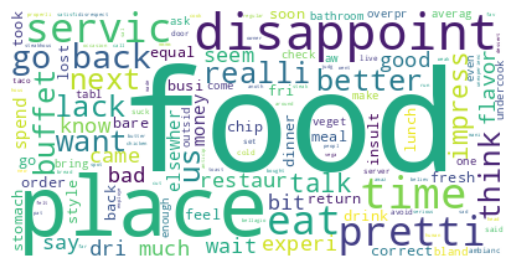

In [ ]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

text = ' '.join(corpus)

# Generate a word cloud image
wordcloud = WordCloud(background_color="white").generate(text)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
X_fresh = cv1.transform(corpus).toarray() # use stemmed dictionary
X_fresh.shape

(100, 1420)

In [ ]:
y_pred = classifier1.predict(X_fresh) # it should be classifier 1. Why is it not working?
print(y_pred)

[0 1 1 0 0 1 0 0 0 1 1 0 0 1 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 1 0
 0 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0]


In [ ]:
df_new['predicted_label'] = y_pred.tolist()
df_new.head(10)

,Review,predicted_label
0,Spend your money elsewhere.,0
1,Their regular toasted bread was equally satisf...,1
2,The Buffet at Bellagio was far from what I ant...,1
3,"And the drinks are WEAK, people!",0
4,-My order was not correct.,0
5,"Also, I feel like the chips are bought, not ma...",1
6,After the disappointing dinner we went elsewhe...,0
7,The chips and sals a here is amazing!!!!!!!!!!...,0
8,We won't be returning.,0
9,This is my new fav Vegas buffet spot.,1


In [ ]:
df_new.predicted_label.value_counts()

,count
predicted_label,
0,79
1,21


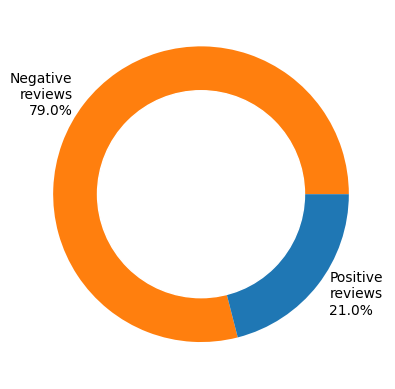

In [ ]:
import matplotlib.pyplot as plt

# Create a pieplot
data = df_new.predicted_label.value_counts().values
plt.pie(data,
        labels = [f'Negative\nreviews\n{data[0] * 100 / (data[0] + data[1])}%',
                  f'Positive\nreviews\n{data[1] * 100 / (data[0] + data[1])}%'],
        colors = ['tab:orange', 'tab:blue'])

# add a circle at the center to transform it in a donut chart
my_circle = plt.Circle((0,0), 0.7, color = 'white')
p = plt.gcf()
p.gca().add_artist(my_circle)

plt.show()


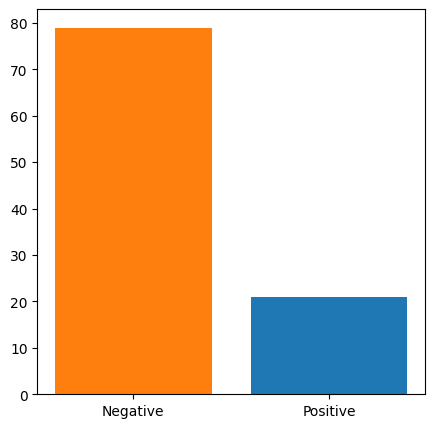

In [ ]:
bars = ('Negative', 'Positive')
y_pos = np.arange(len(bars))

# Create bars
fig = plt.figure(figsize = (5, 5))
plt.bar(y_pos, data, color = ['tab:orange', 'tab:blue'])

# Create names on the x-axis
plt.xticks(y_pos, bars)

# Show graphic
plt.show()


### Analysis with TextBlob

TextBlob: Simplified Text Processing is a Python library for processing textual data. It builds on `nltk` and `pattern` and provides a simple API for diving into common natural language processing (NLP) tasks such as part-of-speech tagging, noun phrase extraction, sentiment analysis, classification, and more. Full list:
- Noun phrase extraction
- Part-of-speech tagging
- Sentiment analysis
- Classification (Naive Bayes, Decision Tree)
- Tokenization (splitting text into words and sentences)
- Word and phrase frequencies
- Parsing
- n-grams
- Word inflection (pluralization and singularization) and lemmatization
- Spelling correction
- Add new models or languages through extensions
- WordNet integration

Two interesting features TextBlob provides are **Polarity** and **Subjectivity**. Polarity indicates the sentiment value that ranges -1 to 1 where close to -1 stands for negative, close to 0 indicates neutral and close to 1 indicates positive sentiment. Subjectivity indicates the review or text contains either factual information or personal opinion.

Docs : https://textblob.readthedocs.io/en/dev/

In [ ]:
example = df.Review[42]
example

"Hard to judge whether these sides were good because we were grossed out by the melted styrofoam and didn't want to eat it for fear of getting sick."

In [ ]:
from textblob import TextBlob

# create textBlob string
text = TextBlob(example)


def getPolarity(text):
    # ranges -1 to 1 whether close to -1 is negative and close to 1 is posivite sentiment and neither close to -1 and 1 is neutral
    polarity = text.sentiment.polarity
    if polarity <= -0.05:
        return f"negative sentiment ({polarity})"
    elif polarity >-0.05 and polarity <0.05:
        return f"neutral sentiment ({polarity})"
    else:
        return f"positive sentiment ({polarity})"

def getSubjectivity(text):
    # it ranges from 0 to 1 whether close to 0 indicates the factual information and close to 1 indicates the personal opinion
    subjectivity =  text.sentiment.subjectivity
    if subjectivity < 0.05:
        return f"factual information ({subjectivity})"
    else:
        return f"personal information ({subjectivity})"


print("Polarity:", getPolarity(text))
print("Subjectivity:", getSubjectivity(text))


Polarity: negative sentiment (-0.10198412698412701)
Subjectivity: personal information (0.6662698412698412)


We could have an overview of the prevalent sentiment in the test dataset based on these two values:

In [ ]:
# create dataframe appending polarity and subjectivity
# ...

df['textblob_polarity'] = [(TextBlob(r)).sentiment.polarity for r in df.Review.values]
df['textblob_subjectivity'] = [(TextBlob(r)).sentiment.subjectivity for r in df.Review.values]

# make simple statistics about overall dataset based on that

# keep in mind that this is a VERY SIMPLE dataset

In [ ]:
df

,Review,Liked,textblob_polarity,textblob_subjectivity
0,Wow... Loved this place.,1,0.400000,0.900000
1,Crust is not good.,0,-0.350000,0.600000
2,Not tasty and the texture was just nasty.,0,-1.000000,1.000000
3,Stopped by during the late May bank holiday of...,1,0.200000,0.700000
4,The selection on the menu was great and so wer...,1,0.800000,0.750000
...,...,...,...,...
895,I want to first say our server was great and w...,1,0.683333,0.694444
896,The pizza selections are good.,1,0.700000,0.600000
897,"I had strawberry tea, which was good.",1,0.700000,0.600000
898,Highly unprofessional and rude to a loyal patron!,0,0.092222,0.657778


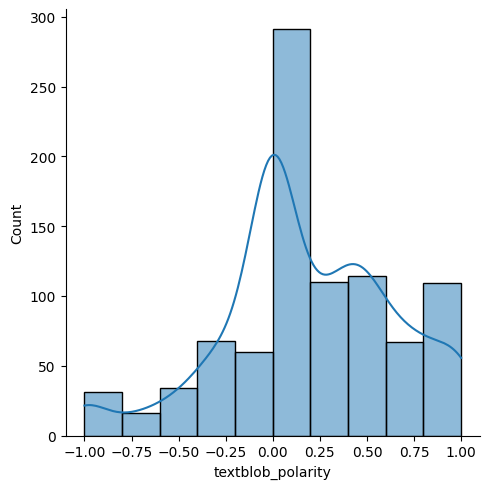

In [ ]:
import seaborn as sns

# Plot the histogram thanks to the displot function
sns.displot(data = df.textblob_polarity, kde = True, bins = 10)<

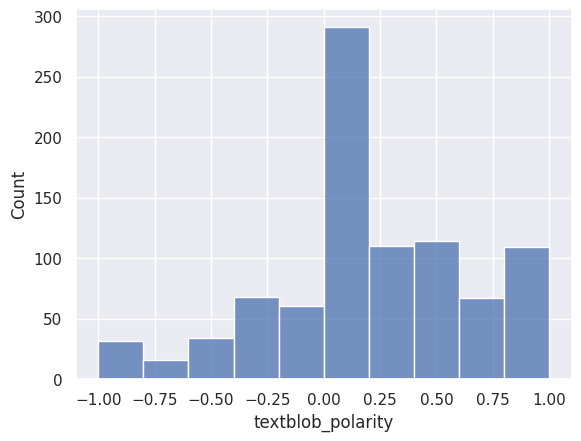

In [ ]:
sns.set_theme(style = "darkgrid")

sns.histplot(data = df, x = "textblob_polarity", bins = 10)
plt.show()

In [ ]:
def normalize(x):
  return (x + 1) / 2

In [ ]:
df['polarity_norm'] = normalize(df['textblob_polarity'])
df['polarity'] = (round(df['polarity_norm'])).astype(int)

df.head()

,Review,Liked,textblob_polarity,textblob_subjectivity,polarity,polarity_norm
0,Wow... Loved this place.,1,0.40,0.90,1,0.700
1,Crust is not good.,0,-0.35,0.60,0,0.325
2,Not tasty and the texture was just nasty.,0,-1.00,1.00,0,0.000
3,Stopped by during the late May bank holiday of...,1,0.20,0.70,1,0.600
4,The selection on the menu was great and so wer...,1,0.80,0.75,1,0.900


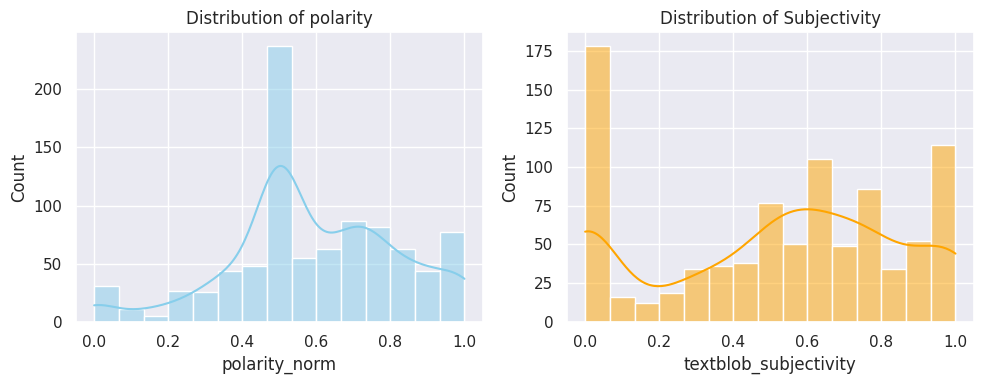

In [ ]:
# Create a figure with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize = (10, 4))

sns.set_theme(style = "darkgrid")

# Plot on the first subplot
sns.histplot(data = df, x = "polarity_norm", bins = 15, color = "skyblue", label = "Polarity", kde = True, ax = axes[0])
axes[0].set_title('Distribution of polarity')

# Plot on the second subplot
sns.histplot(data = df, x = "textblob_subjectivity", bins = 15, color = "orange", label = "Subjectivity", kde = True, ax = axes[1])
axes[1].set_title('Distribution of Subjectivity')

# Adjust the spacing between plots
plt.tight_layout()

# Display the plot
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score

y_true = df.Liked
y_pred = df.polarity

print(accuracy_score(y_true, y_pred))
cm = confusion_matrix(y_true, y_pred)
print(cm)

0.7755555555555556
[[308  96]
 [106 390]]


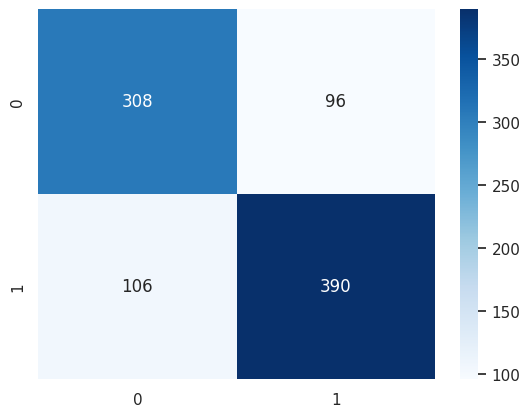

In [ ]:
sns.heatmap(cm, annot=True, cmap = 'Blues', fmt = 'd');

plt.title('TextBlob')
plt.show()

### VADER

VADER stands for Valence Aware Dictionary for Sentiment Reasoning. It also a rule based method that provides sentiment scores based on the words used in the text, specifically designed for social media. It provides separate scores for positive, negative, neutral and compound values.
- Positive, negative and neutral values ranges from 0 to 1 depending on how much positivity, negativity or neutral the content is;
- Compound values ranges from -1 to 1 where close to -1 stands for negative, close to 0 indicates neutral and close to 1 indicates positive.

Docs: https://github.com/cjhutto/vaderSentiment

In [ ]:
!pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 3.9 MB/s eta 0:00:00


In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
# calculate the polarity scores of sentiment text which provides the percentage of
# positivity, negativity, neutral from 0 to 1 and compound from -1 to 1

def get_sentiment_scores(text):
    # create sentiment Intensity Analyzer object
    vader_sia = SentimentIntensityAnalyzer()

    # provides dictionary with pos, neg, neu & compound key and their values
    scores = vader_sia.polarity_scores(text)
    positive = scores['pos'] * 100
    negative = scores['neg'] * 100
    neutral = scores['neu'] * 100
    compound = scores['compound'] * 100
    return scores, positive, neutral, negative, compound

In [ ]:
example = df.Review[0]
example

'Wow... Loved this place.'

In [ ]:
get_sentiment_scores(example)
# returns a tuple (scores, positive, neutral, compound)

({'neg': 0.0, 'neu': 0.206, 'pos': 0.794, 'compound': 0.8271},
 79.4,
 20.599999999999998,
 0.0,
 82.71)

In [ ]:
print(df.Review[1])
get_sentiment_scores(df.Review[1])

Crust is not good.


({'neg': 0.445, 'neu': 0.555, 'pos': 0.0, 'compound': -0.3412},
 0.0,
 55.50000000000001,
 44.5,
 -34.12)

In [ ]:
def vader_sentiment(text):
    # sentiment_scores looks like this
    # {'neg': 0.0, 'neu': 0.698, 'pos': 0.302, 'compound': 0.8313}

    sentiment_scores = get_sentiment_scores(text)
    sentiment_scores = sentiment_scores[0]

    sentiment_scores.pop('compound')
    sentiment_scores.pop('neu') # for this dataset, we don't have neutral labels

    main_sentiment = max(sentiment_scores, key = sentiment_scores.get)

    match main_sentiment:
        case 'neg':
            return 0
        # case 'neu':
        #     return 0.5
        case 'pos':
            return 1


df['vader_score'] = [vader_sentiment(r) for r in df.Review.values]
df.head()

,Review,Liked,vader_score
0,Wow... Loved this place.,1,1
1,Crust is not good.,0,0
2,Not tasty and the texture was just nasty.,0,0
3,Stopped by during the late May bank holiday of...,1,1
4,The selection on the menu was great and so wer...,1,1


In [ ]:
df.vader_score.value_counts()
# if we just keep the maximum sentiment among negative, neutral and positive
# there are way too many neutral values...

,count
vader_score,
1,484
0,416


Too many neutrals, we are not able to evaluate properly on this dataset (there is no label for neutral in the original dataset)

--> look for another dataset!

--> but in the meantime, use just the highest between 'negative' and 'positive'

For evaluation purposes, we don't consider the neutral scores returned by VADER

In [ ]:
# Remove neutrals and only evaluate the rest
#df_vader = df.copy()
#df_vader = df.drop(df['vader_score'] == 0.5)

# Evaluation with only positive and negatives

y_true = df.Liked
y_pred = df.vader_score

print(accuracy_score(y_true, y_pred))
cm = confusion_matrix(y_true, y_pred)
print(cm)

0.8155555555555556
[[327  77]
 [ 89 407]]


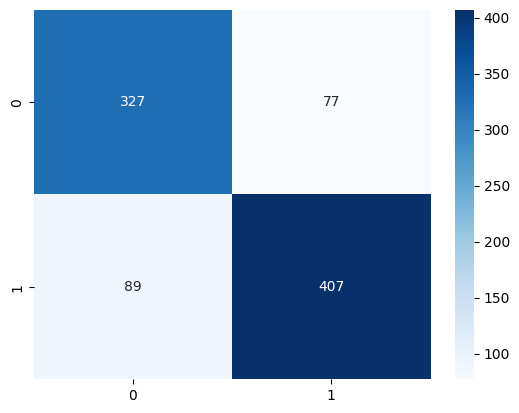

In [ ]:
sns.heatmap(cm, annot=True, cmap = 'Blues', fmt = 'd');

plt.title('VADER')
plt.show()

### Transformers

Going beyond a rule-based approach, we can use transformers to perform Sentiment Analysis: this deep learning approach allows to apply pre-trained models like BERT, RoBERTa and DistilBERT (all Encoders-only transformers) to custom NLP tasks. Transformers hold the state-of-the-art on many Machine Learning tasks. For this task, we can take into account three models:
- **BERT**: devveloped by Google in 2018, this Encoder-only Transformer has a deep understanding of sentence context and produces robust embeddings where each word's representation depends on all the words around it;
- **RoBERTa**: developed by Facebook AI in 2019, it's a more sophisticated version of BERT, pre-trained on more data. It improved its predecessor's performances significantly;
- **DistilBERT**: developed by HuggingFace using knowledge distillation, where a "student" model learns from a "teacher" (here BERT) to mimic its behaviour. Performance is almost the same as BERT but with a reduced model size and increased inference speed.

A summary of the models' characteristics is reported below.

| Model      | Type | Params | Use case |
| ---        | :---: | :---: | --- |
| BERT       |  Bidirectional Encoder-only Transformer | ~110M | Various NLP tasks (Sentiment Analysis, Named Entity Recognition, Question Answering, Text Classification etc.) |
| RoBERTa    | Upgraded BERT | ~125M | More robust pretraining and higher performances than BERT |
| DistilBERT | Compressed BERT | ~66M | Lightweight and nearly as accurate, it's ideal for real-time applications where computational speed is needed |

<br>

For now, we only use the models for inference. However, transformers could be fine-tuned on a dataset of interest to obtain the highest accuracy as possible (near 100% in some cases).

In [ ]:
from transformers import pipeline
# pipeline is a simple but powerful API for *inference* that wires together
# model + tokenizer + preprocessing etc. for a given task, like
# sentiment-analysis, fill-mask, text-generation, summarization etc.

# Initialize the sentiment analysis pipeline
sentiment_pipeline = pipeline("sentiment-analysis",
                              model = "distilbert/distilbert-base-uncased-finetuned-sst-2-english")
                              # NOTICE: SST2 is a binary (positive vs. negative, no neutral) dataset
                              # this is an uncased dataset, makes no difference
                              # use device = 0 for GPU
                              # use return_all_scores = True to inspect both negative and positive scores
# this downloads the model's weights and tokenizer for the specified model
# (look up on HuggingFace other possible models)

# Take the user input
print("\nPlease enter a string: ")
data = input()

# Perform sentiment analysis
results = sentiment_pipeline(data)
label = results[0]['label']
score = results[0]['score']*100

print(f"\nThe sentiment of the String is : {label}")
print(f"The Confidence Score is : {score:.2f}%\n")

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

Device set to use cpu



Please enter a string: 
it was really a not good experience

The sentiment of the String is : NEGATIVE
The Confidence Score is : 99.92%



In [ ]:
example = df.Review[500]
print(example)

# Perform sentiment analysis
results = sentiment_pipeline(example)
label = results[0]['label']
score = results[0]['score']*100

print(f"\nThe sentiment of the String is : {label}")
print(f"The Confidence Score is : {score:.2f}%\n")

I also had to taste my Mom's multi-grain pumpkin pancakes with pecan butter and they were amazing, fluffy, and delicious!

The sentiment of the String is : POSITIVE
The Confidence Score is : 99.99%



In [ ]:
results

[{'label': 'POSITIVE', 'score': 0.9998632669448853}]

In [ ]:
def get_transformer_sentiment(text):
    # keep in mind that sentiment_pipeline returns sth like this
    # [{'label': 'POSITIVE', 'score': 0.9998632669448853}]

    results = sentiment_pipeline(text)
    results = results[0]

    main_sentiment = results['label']

    match main_sentiment:
        case 'NEGATIVE':
            return 0

        case 'POSITIVE':
            return 1

df['transformer_score'] = [get_transformer_sentiment(r) for r in df.Review]
df.head()

,Review,Liked,transformer_score
0,Wow... Loved this place.,1,1
1,Crust is not good.,0,0
2,Not tasty and the texture was just nasty.,0,0
3,Stopped by during the late May bank holiday of...,1,1
4,The selection on the menu was great and so wer...,1,1


In [ ]:
df.transformer_score.value_counts()

,count
transformer_score,
1,496
0,404


In [ ]:
y_true = df.Liked
y_pred = df.transformer_score

print(accuracy_score(y_true, y_pred))
cm = confusion_matrix(y_true, y_pred)
print(cm)

0.9244444444444444
[[370  34]
 [ 34 462]]


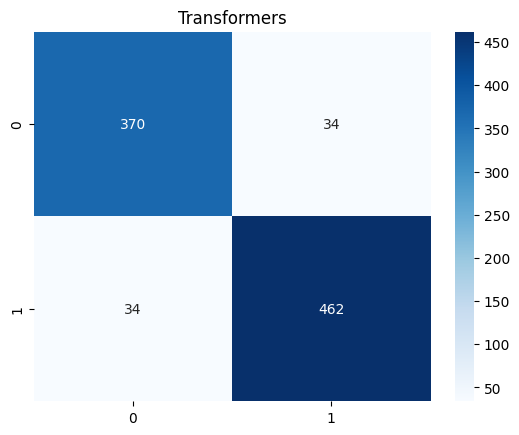

In [ ]:
sns.heatmap(cm, annot=True, cmap = 'Blues', fmt = 'd');

plt.title('Transformers')
plt.show()

Some tries with other transformer models just to compare

In [ ]:
# BERT

sentiment_pipeline_1 = pipeline("sentiment-analysis",
                              model = "textattack/bert-base-uncased-SST-2")
                              # NOTICE: SST2 is a binary (positive vs. negative, no neutral) dataset
                              # this is an uncased dataset, makes no difference
                              # use device = 0 for GPU
                              # use return_all_scores = True to inspect both negative and positive scores
# this downloads the model's weights and tokenizer for the specified model
# (look up on HuggingFace other possible models)

# Take the user input
print("\nPlease enter a string: ")
data = input()

# Perform sentiment analysis
results = sentiment_pipeline_1(data)
label = results[0]['label']
score = results[0]['score']*100

print(f"\nThe sentiment of the String is : {label}")
print(f"The Confidence Score is : {score:.2f}%\n")

config.json:   0%|          | 0.00/477 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cpu



Please enter a string: 
it was overall a not so pleasant experience. Not gonna recommend it

The sentiment of the String is : LABEL_0
The Confidence Score is : 99.75%



In [ ]:
results

[{'label': 'LABEL_0', 'score': 0.9975391626358032}]

In [ ]:
sentiment_pipeline_2 = pipeline("sentiment-analysis",
                              model = "bert-base-uncased") # not finetuned for sentiment analysis it seems

results = sentiment_pipeline_2(data)
label = results[0]['label']
score = results[0]['score']*100

print(f"\nThe sentiment of the String is : {label}")
print(f"The Confidence Score is : {score:.2f}%\n")

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Device set to use cpu



The sentiment of the String is : LABEL_1
The Confidence Score is : 54.84%



In [ ]:
results

[{'label': 'LABEL_1', 'score': 0.5484417080879211}]

In [ ]:
sentiment_pipeline_3 = pipeline("sentiment-analysis",
                              model = "cardiffnlp/twitter-roberta-base-sentiment-latest")

results = sentiment_pipeline_3(data)
label = results[0]['label']
score = results[0]['score']*100

print(results)
print(f"\nThe sentiment of the String is : {label}")
print(f"The Confidence Score is : {score:.2f}%\n")

config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Device set to use cpu


[{'label': 'negative', 'score': 0.929201602935791}]

The sentiment of the String is : negative
The Confidence Score is : 92.92%



### References

Practical:

- Restaurant's basic example (Naive Bayes as classifier): [Medium](https://medium.com/@skillcate/sentiment-analysis-project-with-traditional-ml-nlp-349185bf98dd), [Google Drive](https://drive.google.com/drive/folders/1KgvHQAaYwprkQJTTOf3TH8OJ_e3SbSGI)
- Sentiment Analysis with TextBlob, VADER and transformers - pt.1 [Medium](https://medium.com/@abdullah.iu.cse/sentiment-analysis-with-textblob-vader-transformers-abe045a2e406)
- Sentiment Analysis with TextBlob, VADER and transformers app on Streamlit - pt.2 [Medium](https://medium.com/@abdullah.iu.cse/sentiment-analysis-project-with-streamlit-web-app-0acdb79cb088)
- In depth series: Sentiment Analysis w Transformers [Kaggle](
https://www.kaggle.com/code/emirkocak/in-depth-series-sentiment-analysis-w-transformers)

Theoretical:

- BERT 101 explained, [HuggingFace](https://huggingface.co/blog/bert-101)

## 1) Amazon Product reviews

https://www.kaggle.com/datasets/arhamrumi/amazon-product-reviews

In [ ]:
!pip install kagglehub[pandas-datasets]

In [ ]:
# Install dependencies as needed:
# pip install kagglehub[pandas-datasets]
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path to the file you'd like to load
file_path = "Reviews.csv"

# Load the latest version
df = kagglehub.dataset_load(
  KaggleDatasetAdapter.PANDAS,
  "arhamrumi/amazon-product-reviews",
  file_path,
  # Provide any additional arguments like
  # sql_query or pandas_kwargs. See the
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)

print("First 5 records:", df.head())

/tmp/ipython-input-624819089.py:10: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df = kagglehub.load_dataset(


Using Colab cache for faster access to the 'amazon-product-reviews' dataset.
First 5 records:    Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      5  1303862400   
1                     0                       0      1  1346976000   
2                     1                       1      4  1219017600   
3                     3                       3      2  1307923200   
4                     0                       0      5  1350777600   

                 Summary                                        

In [ ]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [ ]:
df.shape

(568454, 10)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568428 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [ ]:
df.ProductId.value_counts()

,count
ProductId,
B007JFMH8M,913
B002QWHJOU,632
B0026RQTGE,632
B002QWP89S,632
B002QWP8H0,632
...,...
B000M6CTGK,1
B000MAST88,1
B0064KU9HO,1


In [ ]:
df[df.ProductId == 'B002QWP8H0'].Score.value_counts()

,count
Score,
5,498
4,74
1,27
3,21
2,12


Problem: lots of information, feedback, comments, reviews, but most of it (unless it comes with a star rating or siilar) is *unstructured* information. These are more difficult to handle, because it can't be done numerically and aggregation is difficult. NLP and SA come at hand here, to predict sentiments from unstructured data at scale.

Business case: we want to build a binary (positive vs. negative) review classification model that can help us understand the customer's feelings about a product (or a restaurant, or something else for which they left a review).

## Pi School 16 projects
- **Information extraction:** Trallie: open source project to handle unstructured data + GPT4o mini (to extract unstructured information from a 50 + pages of pdf and put them into a table)
- **Anomaly Detection** Explainable Anomaly Detection project for components of molder injection factories (?), they predict if the component will be defective or not 12 secs before it is produced + it tells you what is possibly wrong! Not only if it is wrong.
- **Confidential speech-to-text translation** Real Time confidential translation systems! chunking and buffering to make it more real time, open source pretrained models, Whisper to convert speech to text, then translate it, then coconut model(?) to convert text into audio. The pipeline works completely offline, so guarantees confidentiality. Later added a glossary of technical terms to make the model more expert about the specific context -> blue score, comet score (how good a machine translation is compared to a human translation). good that it can run on local devices, for training programs